In [1]:
current_dir = %pwd
image_dir = current_dir + '/../images'
result_dir = current_dir + '/../results'

In [2]:
from common import *
from scipy import stats
import os
import re
import json
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import *
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
%matplotlib inline
#plt.style.use('ggplot')
print plt.style.available
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib
[u'grayscale', u'bmh', u'dark_background', u'ggplot', u'fivethirtyeight']


In [3]:
game_names = {
    'ms_pacman': 'Ms. Pacman',
    'space_invaders': 'Space Invaders',
    'freeway': 'Freeway',
    'pong': 'Pong',
    'seaquest': 'Seaquest',
    'frostbite': 'Frostbite',
}
exp_re= re.compile('(?P<experiment>.*?)' +
               '([_-]+rep.(?P<rep>[0-9]+))?' +
               '([_-]+(?P<date>[0-9]{2}-[0-9]{2}.*?))?$')

In [4]:
from scipy import stats

def process_results(results, num_reps=None, num_epochs=100):
    if num_reps is None:
        num_reps = len(results)
    rewards = np.empty((num_reps, num_epochs))
    qs = np.empty((num_reps, num_epochs))
    for rep in range(num_reps):
        results[rep]
        rewards[rep, ...] = results[rep]['reward_per_episode'][:num_epochs]
        qs[rep, ...] = results[rep]['mean_q'][:num_epochs]
    return rewards, qs
            
def process_results_for_games(results, games, num_reps=5, num_epochs=100):
    rewards = np.empty((num_games, num_reps, num_epochs))
    qs = np.empty((num_games, num_reps, num_epochs))
    for game_i, game in enumerate(games):
        rewards[game_i], qs[game_i] = process_results(results[game], num_reps, num_epochs)
    return rewards, qs

labelify = lambda labels: map(lambda l: l if int(l) < 1000 else str(int(l) / 1000) + 'k', labels)

In [36]:
single_base_dir = result_dir + '/single_frame'
base_dir = result_dir + '/base'
single_learning, single_results, single_params = gather(single_base_dir)
base_learning, base_results, base_params = gather(base_dir)

phi_1-pong 
long_pong-pong 


In [37]:
single_rewards, single_qs = process_results(single_results['phi_1-pong'])
single_rewards_err = stats.sem(single_rewards, axis=0)
single_rewards_mean = np.mean(single_rewards, axis=0)
single_qs_err = stats.sem(single_qs, axis=0)
single_qs_mean = np.mean(single_qs, axis=0)

# Mind you this is actually 200 epochs but don't need them all
base_rewards, base_qs = process_results(base_results['long_pong-pong'])
base_rewards_err = stats.sem(base_rewards, axis=0)
base_rewards_mean = np.mean(base_rewards, axis=0)
base_qs_err = stats.sem(base_qs, axis=0)
base_qs_mean = np.mean(base_qs, axis=0)

## Frame Stacking

In [50]:
num_epochs = 100
num_reps = 5

base_boost_dir = result_dir + '/base_boost'
single_frame_boost_dir = result_dir + '/single_frame_boost'

base_boost_learning, base_boost_results, base_boost_params = gather(base_boost_dir)
single_boost_learning, single_boost_results, single_boost_params = gather(single_frame_boost_dir)

games = base_boost_results.keys()
num_games = len(games)

freeway ms_pacman pong seaquest space_invaders 
freeway ms_pacman pong seaquest space_invaders 


In [51]:
base_boost_rewards, base_boost_qs = process_results_for_games(base_boost_results, games)
single_boost_rewards, single_boost_qs = process_results_for_games(single_boost_results, games)

In [52]:
base_boost = None
print base_boost_rewards.shape
base_boost_rewards_err = stats.sem(base_boost_rewards, axis=1)
base_boost_rewards_mean = np.mean(base_boost_rewards, axis=1)
#base_boost_rewards_max = np.max(base_boost_rewards, axis=1)
#base_boost_rewards_min = np.min(base_boost_rewards, axis=1)
single_boost_rewards_err = stats.sem(single_boost_rewards, axis=1)
single_boost_rewards_mean = np.mean(single_boost_rewards, axis=1)

base_boost_qs_err = stats.sem(base_boost_qs, axis=1)
base_boost_qs_mean = np.mean(base_boost_qs, axis=1)
single_boost_qs_err = stats.sem(single_boost_qs, axis=1)
single_boost_qs_mean = np.mean(single_boost_qs, axis=1)


(5, 5, 100)


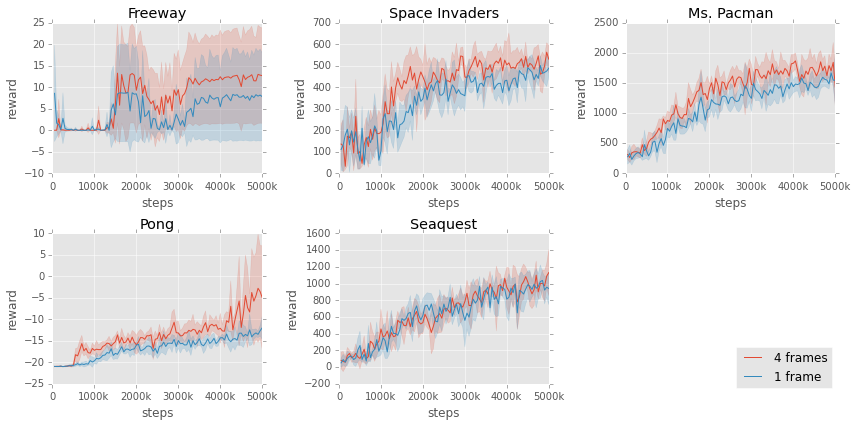

In [14]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)
s = lambda x: x

epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

fig = plt.figure(figsize=(12,6))
lines = []
for game_i, game in enumerate(games):
    #base_ax = fig.add_subplot(num_games, 2, game_i * 2 + 1)
    #single_ax = fig.add_subplot(num_games, 2, game_i * 2 + 2)
    ax = fig.add_subplot(2, 3, game_i + 1)
    base_line, = ax.plot(steps, s(base_boost_rewards_mean[game_i]),
                        label='4 frames')
    ax.fill_between(steps, 
                    s(base_boost_rewards_mean[game_i]) - t * s(base_boost_rewards_err[game_i]),
                    s(base_boost_rewards_mean[game_i]) + t * s(base_boost_rewards_err[game_i]),
                    #base_boost_rewards_min[game_i],
                    #base_boost_rewards_max[game_i],
                    alpha=0.2,
                    color = base_line.get_color())
    single_line, = ax.plot(steps, single_boost_rewards_mean[game_i],
                          label='1 frame')
    ax.fill_between(steps, 
                s(single_boost_rewards_mean[game_i]) - t * s(single_boost_rewards_err[game_i]),
                s(single_boost_rewards_mean[game_i]) + t * s(single_boost_rewards_err[game_i]),
                alpha=0.2,
                color = single_line.get_color())
    ax.set_title(game_names[game])
    ax.set_xlabel('steps')
    ax.set_ylabel('reward')
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labelify(labels))
    
    lines += [base_line, single_line]

fig.legend(lines, labels=['4 frames', '1 frame'], bbox_to_anchor=(.97, 0.2))
fig.tight_layout()
plt.savefig(image_dir + '/stacked_vs_single.pdf')

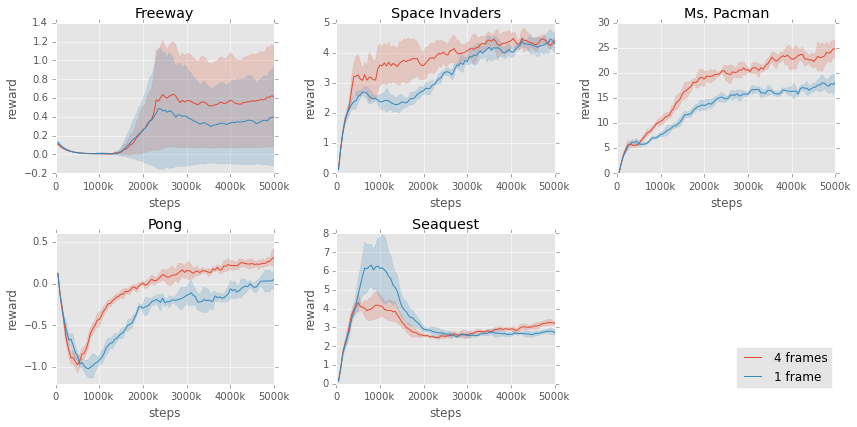

In [12]:
#s = partial(smoothing, window=3)
s = lambda x: x
fig = plt.figure(figsize=(12,6))
lines = []
for game_i, game in enumerate(games):
    #base_ax = fig.add_subplot(num_games, 2, game_i * 2 + 1)
    #single_ax = fig.add_subplot(num_games, 2, game_i * 2 + 2)
    ax = fig.add_subplot(2, 3, game_i + 1)
    base_line, = ax.plot(steps, s(base_boost_qs_mean[game_i]),
                        label='4 frames')
    ax.fill_between(steps, 
                    s(base_boost_qs_mean[game_i]) - t * s(base_boost_qs_err[game_i]),
                    s(base_boost_qs_mean[game_i]) + t * s(base_boost_qs_err[game_i]),
                    #base_boost_qs_min[game_i],
                    #base_boost_qs_max[game_i],
                    alpha=0.2,
                    color = base_line.get_color())
    single_line, = ax.plot(steps, s(single_boost_qs_mean[game_i]),
                          label='1 frame')
    ax.fill_between(steps, 
                s(single_boost_qs_mean[game_i]) - t * s(single_boost_qs_err[game_i]),
                s(single_boost_qs_mean[game_i]) + t * s(single_boost_qs_err[game_i]),
                alpha=0.2,
                color = single_line.get_color())
    ax.set_title(game_names[game])
    ax.set_xlabel('steps')
    ax.set_ylabel('reward')
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labelify(labels))
    
    lines += [base_line, single_line]

fig.legend(lines, labels=['4 frames', '1 frame'], bbox_to_anchor=(.97, 0.2))
fig.tight_layout()
plt.savefig(image_dir + '/stacked_vs_single_qs.pdf')

## Late Fusion

## 3D Conv

In [79]:
conv3d_dir = result_dir + '/conv3d'

num_epochs = 100

conv3d_learning, conv3d_results, conv3d_params = gather(conv3d_dir)
conv3d = {k: process_results(v) for k, v in conv3d_results.iteritems()}
conv3d_rewards = {k: v[0] for k, v in conv3d.iteritems()}
conv3d_qs = {k: v[1] for k, v in conv3d.iteritems()}

for k,v in conv3d.iteritems():
    print k, '\t', v[0].shape

conv3d_10-pong conv3d_2_2_maxpool-pong conv3d_2_2_nopool-pong conv3d_2_3-pong conv3d_3_1-pong conv3d_3_2-pong conv3d_rgb-pong 
conv3d_3_2-pong 	(2, 100)
conv3d_3_1-pong 	(2, 100)
conv3d_10-pong 	(1, 100)
conv3d_rgb-pong 	(2, 100)
conv3d_2_2_nopool-pong 	(1, 100)
conv3d_2_2_maxpool-pong 	(2, 100)
conv3d_2_3-pong 	(2, 100)


In [80]:
conv3d_rewards_mean = {k: np.mean(v, axis=0) for k, v in conv3d_rewards.iteritems()}
conv3d_qs_mean = {k: np.mean(v, axis=0) for k, v in conv3d_qs.iteritems()}
conv3d_rewards_err = {k: stats.sem(v, axis=0) for k, v in conv3d_rewards.iteritems()}
conv3d_qs_err = {k: stats.sem(v, axis=0) for k, v in conv3d_qs.iteritems()}

In [91]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=3)
#s = lambda x:x

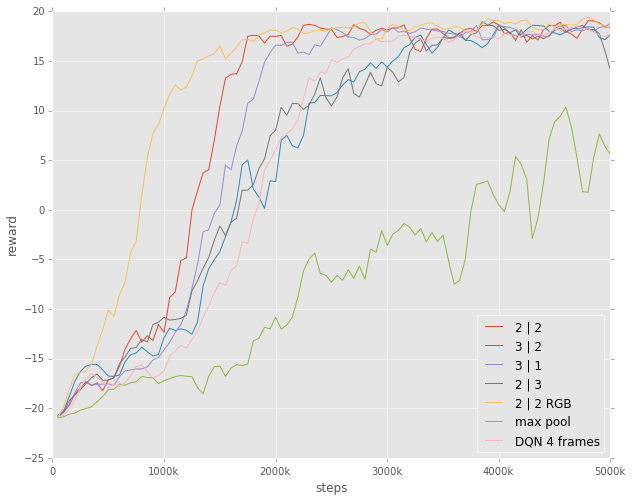

In [101]:

fig = plt.figure(figsize=(10,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_2_nopool-pong']),
       label='2 | 2')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_3_2-pong']),
       label='3 | 2')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_3_1-pong']),
       label='3 | 1')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_3-pong']),
       label='2 | 3')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_rgb-pong']),
       label='2 | 2 RGB')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_2_maxpool-pong']),
       label='max pool')
ax.plot(steps, s(base_rewards_mean), label='DQN 4 frames')
#ax.plot(steps, s(single_rewards_mean), label='DQN 1 frame')


fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')
plt.savefig(image_dir + '/conv3d_rewards.pdf')

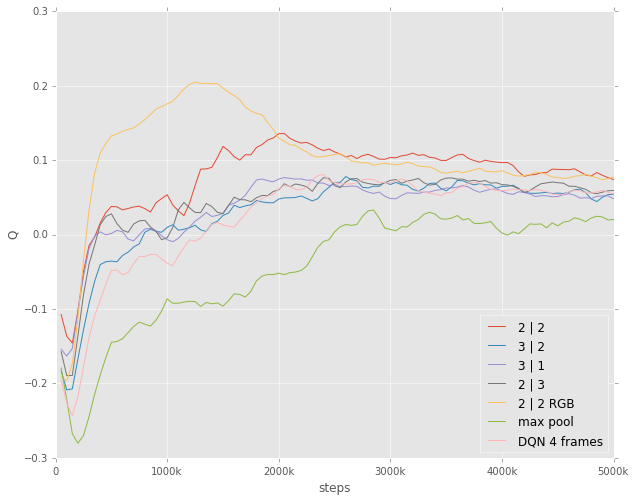

In [100]:
fig = plt.figure(figsize=(10,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_2_nopool-pong']),
       label='2 | 2')
ax.plot(steps, s(conv3d_qs_mean['conv3d_3_2-pong']),
       label='3 | 2')
ax.plot(steps, s(conv3d_qs_mean['conv3d_3_1-pong']),
       label='3 | 1')
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_3-pong']),
       label='2 | 3')
ax.plot(steps, s(conv3d_qs_mean['conv3d_rgb-pong']),
       label='2 | 2 RGB')
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_2_maxpool-pong']),
       label='max pool')
ax.plot(steps, s(base_qs_mean), label='DQN 4 frames')
#ax.plot(steps, s(single_qs_mean), label='DQN 1 frame')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('Q')

plt.legend(loc='lower right')
plt.savefig(image_dir + '/conv3d_qs.pdf')

## Late Fusion

In [15]:
late_fusion_dir = result_dir + '/late_fusion'

num_epochs = 100

late_fusion_learning, late_fusion_results, late_fusion_params = gather(late_fusion_dir)
late_fusion = {k: process_results(v) for k, v in late_fusion_results.iteritems()}
late_fusion_rewards = {k: v[0] for k, v in late_fusion.iteritems()}
late_fusion_qs = {k: v[1] for k, v in late_fusion.iteritems()}

for k,v in late_fusion.iteritems():
    print k, '\t', v[0].shape


late_fusion_4_noshare-pong late_fusion_4_rgb-pong late_fusion_4_share-pong 
late_fusion_4_share-pong 	(1, 100)
late_fusion_4_noshare-pong 	(1, 100)
late_fusion_4_rgb-pong 	(1, 100)


In [16]:
late_fusion_rewards_mean = {k: np.mean(v, axis=0) for k, v in late_fusion_rewards.iteritems()}
late_fusion_qs_mean = {k: np.mean(v, axis=0) for k, v in late_fusion_qs.iteritems()}
late_fusion_rewards_err = {k: stats.sem(v, axis=0) for k, v in late_fusion_rewards.iteritems()}
late_fusion_qs_err = {k: stats.sem(v, axis=0) for k, v in late_fusion_qs.iteritems()}

/home/ruben/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/ruben/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


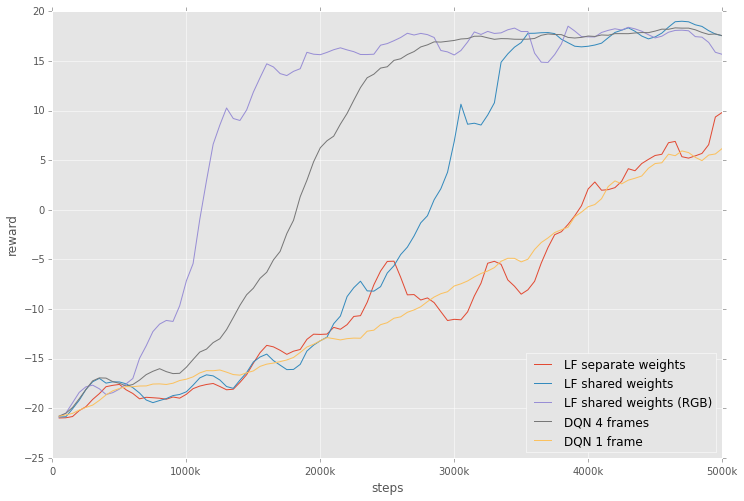

In [33]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(12,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(late_fusion_rewards_mean['late_fusion_4_noshare-pong']),
       label='LF separate weights')
ax.plot(steps, s(late_fusion_rewards_mean['late_fusion_4_share-pong']),
       label='LF shared weights')
ax.plot(steps, s(late_fusion_rewards_mean['late_fusion_4_rgb-pong']),
       label='LF shared weights (RGB)')
ax.plot(steps, s(base_rewards_mean), label='DQN 4 frames')
ax.plot(steps, s(single_rewards_mean), label='DQN 1 frame')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')
plt.savefig(image_dir + '/late_fusion_pong_rewards.pdf')

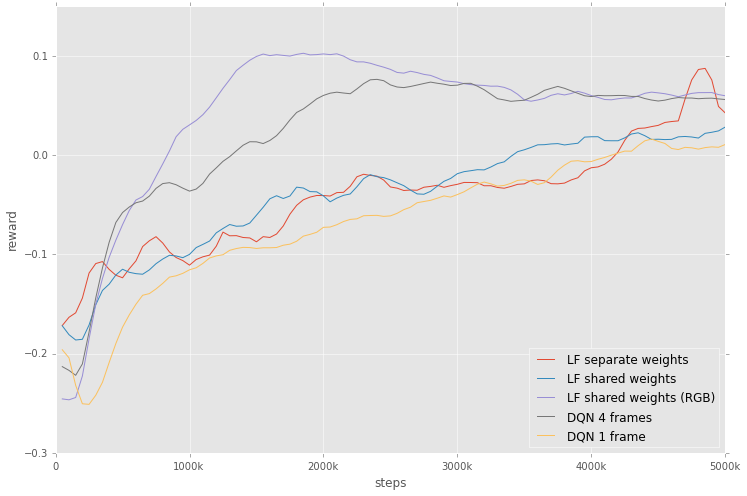

In [32]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)
#s = lambda x:x

fig = plt.figure(figsize=(12,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(late_fusion_qs_mean['late_fusion_4_noshare-pong']),
       label='LF separate weights')
ax.plot(steps, s(late_fusion_qs_mean['late_fusion_4_share-pong']),
       label='LF shared weights')
ax.plot(steps, s(late_fusion_qs_mean['late_fusion_4_rgb-pong']),
       label='LF shared weights (RGB)')
ax.plot(steps, s(base_qs_mean), label='DQN 4 frames')
ax.plot(steps, s(single_qs_mean), label='DQN 1 frame')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')
plt.savefig(image_dir + '/late_fusion_pong_qs.pdf')

## Flickering

In [5]:
flicker_dir = result_dir + '/flicker'
flicker_learning, flicker_results, flicker_params = gather(flicker_dir)

num_epochs = 100

flicker = {k: process_results(v) for k, v in flicker_results.iteritems()}
flicker_rewards = {k: v[0] for k, v in flicker.iteritems()}
flicker_qs = {k: v[1] for k, v in flicker.iteritems()}

for k,v in flicker.iteritems():
    print k, '\t', v[0].shape
    
flicker_rewards_mean = {k: np.mean(v, axis=0) for k, v in flicker_rewards.iteritems()}
flicker_qs_mean = {k: np.mean(v, axis=0) for k, v in flicker_qs.iteritems()}


conv3d_10_flicker-pong conv3d_4_flicker-pong pong_flicker_.5 pong_flicker_10_.5-pong 
conv3d_10_flicker-pong 	(1, 100)
pong_flicker_.5 	(1, 100)
conv3d_4_flicker-pong 	(1, 100)
pong_flicker_10_.5-pong 	(1, 100)


In [7]:
confidence = 0.9
num_reps=3
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

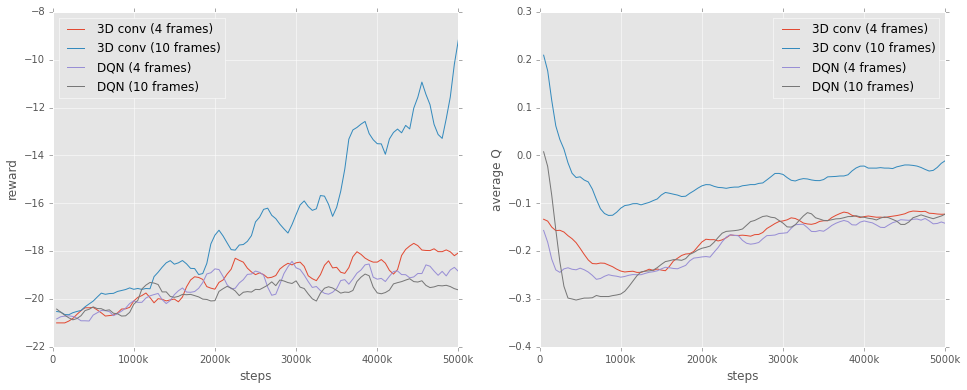

In [13]:
fig = plt.figure(figsize=(16,6))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax1 = fig.add_subplot(121)
ax1.plot(steps, s(flicker_rewards_mean['conv3d_4_flicker-pong']),
       label='3D conv (4 frames)')
ax1.plot(steps, s(flicker_rewards_mean['conv3d_10_flicker-pong']),
       label='3D conv (10 frames)')
ax1.plot(steps, s(flicker_rewards_mean['pong_flicker_.5']),
       label='DQN (4 frames)')
ax1.plot(steps, s(flicker_rewards_mean['pong_flicker_10_.5-pong']),
       label='DQN (10 frames)')

fig.canvas.draw()
labels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labelify(labels))
ax1.set_xlabel('steps')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(122)
ax2.plot(steps, s(flicker_qs_mean['conv3d_4_flicker-pong']),
       label='3D conv (4 frames)')
ax2.plot(steps, s(flicker_qs_mean['conv3d_10_flicker-pong']),
       label='3D conv (10 frames)')
ax2.plot(steps, s(flicker_qs_mean['pong_flicker_.5']),
       label='DQN (4 frames)')
ax2.plot(steps, s(flicker_qs_mean['pong_flicker_10_.5-pong']),
       label='DQN (10 frames)')

fig.canvas.draw()
labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labelify(labels))
ax2.set_xlabel('steps')
ax2.set_ylabel('average Q')
ax2.legend(loc='upper right')

plt.savefig(image_dir + '/conv3d_flicker_both.pdf')

## Extra

In [43]:
nn_dir = result_dir + '/nature_network'
nn_learning, nn_results, nn_params = gather(nn_dir)

num_epochs = 100

nn = {k: process_results(v) for k, v in nn_results.iteritems()}
nn_rewards = {k: v[0] for k, v in nn.iteritems()}
nn_qs = {k: v[1] for k, v in nn.iteritems()}

for k,v in nn.iteritems():
    print k, '\t', v[0].shape
    
nn_rewards_mean = {k: np.mean(v, axis=0) for k, v in nn_rewards.iteritems()}
nn_qs_mean = {k: np.mean(v, axis=0) for k, v in nn_qs.iteritems()}

pong space_invaders 
space_invaders 	(5, 100)
pong 	(5, 100)


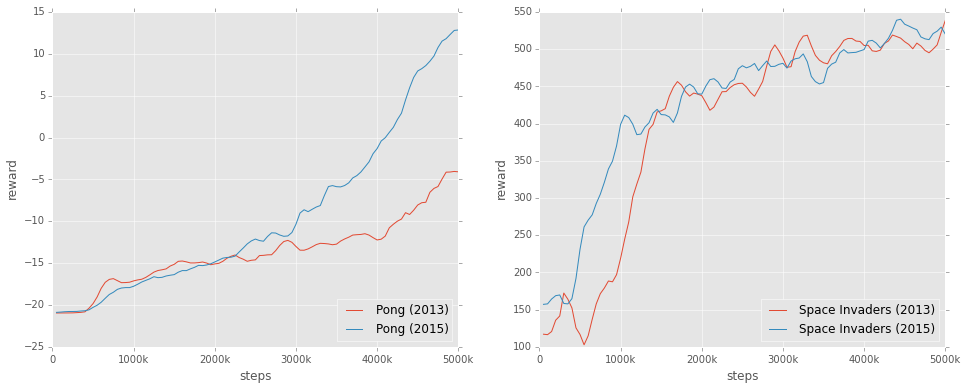

In [77]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(16,6))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax1 = fig.add_subplot(121)
ax1.plot(steps, s(base_boost_rewards_mean[3]),
       label='Pong (2013)')
ax1.plot(steps, s(nn_rewards_mean['pong']),
       label='Pong (2015)')

fig.canvas.draw()
labels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labelify(labels))
ax1.set_xlabel('steps')
ax1.set_ylabel('reward')
ax1.legend(loc='lower right')

ax2 = fig.add_subplot(122)
ax2.plot(steps, s(base_boost_rewards_mean[1]),
       label='Space Invaders (2013)')
ax2.plot(steps, s(nn_rewards_mean['space_invaders']),
       label='Space Invaders (2015)')

fig.canvas.draw()
labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labelify(labels))
ax2.set_xlabel('steps')
ax2.set_ylabel('reward')
ax2.legend(loc='lower right')

plt.savefig(image_dir + '/nips_vs_nature_rewards.pdf')

In [57]:
base_boost_rewards_mean[3]

array([  311.07847169,   260.90598076,   339.97135128,   355.02014872,
         357.77559924,   348.16269449,   335.34857714,   474.94843256,
         377.31021605,   409.12084485,   517.07242351,   565.39749461,
         587.3605696 ,   629.95495678,   680.43615575,   750.76302521,
         674.32976669,   901.86470588,   821.51413361,   876.23245366,
         863.49111862,   967.07321713,   985.33618045,  1139.65168191,
         987.80866627,   926.84575163,   910.64737273,   976.6954379 ,
         972.24213861,  1243.37171717,  1105.66571638,  1172.48682488,
        1257.90481006,  1353.83711001,  1377.15086207,  1508.14942529,
        1307.19649699,  1325.8266427 ,  1223.70614653,  1407.9729064 ,
        1504.43221671,  1320.66707326,  1580.31317101,  1472.12727619,
        1292.80694037,  1520.35927751,  1504.43156358,  1388.63589173,
        1501.04876847,  1548.75767196,  1616.2315271 ,  1434.90336134,
        1562.67682575,  1602.96321839,  1588.78658827,  1484.28498332,
      